In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [4]:
%%time
test = pd.read_csv('test.csv', index_col = 0)
train = pd.read_csv('train.csv', index_col = 0)
# train.head()
# train.info()
# test.info()
### encode values: Sex
train.Sex = train.Sex.apply(lambda x: 1 if x=='male' else 0)
test.Sex = test.Sex.apply(lambda x: 1 if x=='male' else 0)

### impute missing or zero Fare values with median Fares for each Pclass
train.loc[(train.Fare==0)&(train.Pclass==1),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][1]
train.loc[(train.Fare==0)&(train.Pclass==2),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][2]

train.loc[(train.Fare==0)&(train.Pclass==3),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][3]

test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==1),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][1]
test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==2),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][2]

test.loc[((pd.isnull(test['Fare'])==True)|(test.Fare==0))&(test.Pclass==3),"Fare"] = train[(train['Fare']!=0)]\
                                                                .groupby('Pclass')['Fare'].describe()['50%'][3]

# extract titles from names
def title_extractor(row):
    return row.split(',')[1].strip().split('.')[0]
titles_train = train.Name.apply(title_extractor)
titles_test = test.Name.apply(title_extractor)
titles_train = titles_train.map({'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master','Dr':'Dr','Rev':'Rev',
                                   'Don':'Mr', 'Mlle':'Miss', 'Lady':'Mrs', 'Ms':'Mrs', 
                                   'Mme':'Mrs', 'the Countess': 'Mrs', 'Col':'Mr','Major':'Mr',
                                  'Sir':'Mr','Jonkheer':'Mr','Capt':'Mr'})
titles_test = titles_test.map({'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master','Dr':'Dr','Rev':'Rev',
                                   'Don':'Mr', 'Mlle':'Miss', 'Lady':'Mrs', 'Ms':'Mrs', 
                                   'Mme':'Mrs', 'the Countess': 'Mrs', 'Col':'Mr','Major':'Mr',
                                  'Sir':'Mr','Jonkheer':'Mr','Capt':'Mr',
                              'Dona':'Mrs'})

if 'Title' not in train.columns:
    train['Title'] = titles_train
    title_encoded_train = pd.get_dummies(train.Title, prefix_sep = '_', drop_first = True)
    train = pd.concat([train, title_encoded_train], axis = 1)
if 'Title' not in test.columns:
    test['Title'] = titles_test
    title_encoded_test = pd.get_dummies(test.Title, prefix_sep = '_', drop_first = True)
    test = pd.concat([test, title_encoded_test], axis = 1)

#encode port of embarkation
train = pd.concat([train, pd.get_dummies(train.Embarked, prefix_sep = '_', drop_first = True)], axis = 1)
test = pd.concat([test, pd.get_dummies(test.Embarked, prefix_sep = '_', drop_first = True)], axis = 1)

# add Family size, IsAlone and Has_Cabin

train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(np.int8)
test['IsAlone'] = (test['FamilySize'] == 1).astype(np.int8)
train['HasCabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['HasCabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

    #categorical columns
col_types = train.dtypes.to_frame().reset_index()
cat_cols = col_types.loc[col_types[0]=='object']['index']
cat_cols

### ### impute Age by prediction with random forest regressor
#y and X sets for Age
y_age = train[pd.isnull(train['Age'])==False]['Age']
X_age = train[pd.isnull(train['Age'])==False].drop(cat_cols,axis=1).drop(['Age','Survived'],axis=1)

#train and val split for Age 
X_age_train, X_age_val, y_age_train, y_age_val = train_test_split(X_age, y_age, test_size = 0.25, random_state = 21)

# select entries with missing Age
X_nullage = train[pd.isnull(train['Age'])==True].drop(cat_cols,axis=1).drop(['Age','Survived'],axis=1)

# instantiate random forest regressor
age_reg = RandomForestRegressor(max_depth=4, random_state=21)
age_reg.fit(X_age_train, y_age_train)

# predict age for train and val sets
y_age_train_pred = age_reg.predict(X_age_train)
y_age_val_pred = age_reg.predict(X_age_val)

# check mean square erorrs and compare to simple median age imputer
print(f'train age MSE: {mean_squared_error(y_age_train, y_age_train_pred)}')
print(f'valid age MSE: {mean_squared_error(y_age_val, y_age_val_pred)}')
print(f'median age MSE: {mean_squared_error(y_age_val, np.asarray([y_age.median() for i in range(len(y_age_val))]))}')

# predict misisng Age values
age_imputed = age_reg.predict(X_nullage)
# replace null Age with predictions
X_nullage['Age'] = age_imputed
train.Age.loc[X_nullage['Age'].index] = X_nullage['Age'].copy()

### test set age imputation
test_nullage = test[pd.isnull(test['Age'])==True].drop(cat_cols,axis=1).drop('Age',axis=1)
age_test_imputed = age_reg.predict(test[pd.isnull(test['Age'])==True].drop(cat_cols,axis=1).drop('Age',axis=1))
test_nullage['Age'] = age_test_imputed
test.Age.loc[test_nullage['Age'].index] = test_nullage['Age'].copy()

train age MSE: 108.90607454508152
valid age MSE: 116.78580854916186
median age MSE: 236.75963240223462
Wall time: 282 ms


C:\Users\pavlo\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\pavlo\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
train = train.drop(cat_cols, axis = 1)
test = test.drop(cat_cols, axis = 1)

In [14]:
import xgboost as xgb

In [41]:
### fitting model
X, y = train.drop(['Survived'], axis = 1), train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 21)

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 8}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train, eval_metric='error', eval_set=[[X_train, y_train], [X_val, y_val]])


print(f'train score: {clf_xgb.score(X_train, y_train)}') #0.83 with mean age imputer
print(f'valid score: {clf_xgb.score(X_val, y_val)}') #0.807175 mean age imputer for max_depth=4

best_params = params

[0]	validation_0-error:0.15569	validation_1-error:0.20179
[1]	validation_0-error:0.13922	validation_1-error:0.17937
[2]	validation_0-error:0.13772	validation_1-error:0.17937
[3]	validation_0-error:0.12425	validation_1-error:0.17937
[4]	validation_0-error:0.12425	validation_1-error:0.17937
[5]	validation_0-error:0.12874	validation_1-error:0.17937
[6]	validation_0-error:0.13024	validation_1-error:0.17937
[7]	validation_0-error:0.12575	validation_1-error:0.18386
[8]	validation_0-error:0.13024	validation_1-error:0.18386
[9]	validation_0-error:0.12725	validation_1-error:0.18386
[10]	validation_0-error:0.12425	validation_1-error:0.17937
[11]	validation_0-error:0.12126	validation_1-error:0.18386
[12]	validation_0-error:0.12275	validation_1-error:0.18386
[13]	validation_0-error:0.12874	validation_1-error:0.18386
[14]	validation_0-error:0.12425	validation_1-error:0.17937
[15]	validation_0-error:0.12275	validation_1-error:0.17937
[16]	validation_0-error:0.12425	validation_1-error:0.18386
[17]	va

Text(0.5, 0, 'iteration number')

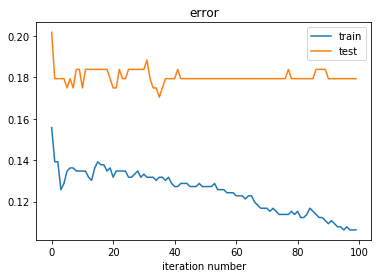

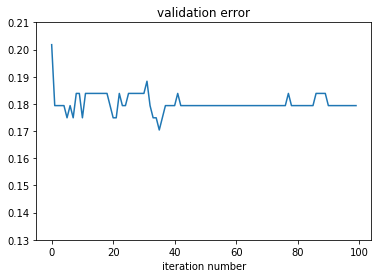

In [28]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['error'],
                         'test': clf.evals_result()['validation_1']['error']})
res = save_online_metric(clf_xgb)
res.plot(title='error')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.13,0.21), title='validation error')
plt.xlabel('iteration number')

In [38]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [37]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 21)
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kf,
                  verbose=3,)

    clf.fit(X, y)
    best_params = clf.best_estimator_.get_params()
    print('Best test accuracy: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

In [46]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [8,9,10],
    'min_child_weight': [5, 6, 7],#[1, 5, 10]
    'n_jobs': [8]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.800, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.843, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.809, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.775, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.831, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.843, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.854, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.854, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=8, score=0.820, total=   0.1s
[CV] max_depth=8, min_child_weight=5, n_jobs=8 .......................
[CV]  max_depth=8, min_child_weight=5, n_jobs=

[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.843, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.820, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.787, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.820, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.854, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.865, total=   0.1s
[CV] max_depth=10, min_child_weight=5, n_jobs=8 ......................
[CV]  max_depth=10, min_child_weight=5, n_jobs=8, score=0.854, total=   0.1s
[CV] max_depth=10, min_child_weight

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    5.0s finished


In [52]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0.6, 0.8, 100),
    'n_jobs': [8]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................. gamma=0.6, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.798, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.843, total=   0.0s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] ................. gamma=0.6, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.6, n_jobs=8 .............................................
[CV] .

[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .. gamma=0.6121212121212121, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6121212121212121, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6222222222222222, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .. gamma=0.6242424242424243, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.6242424242424243, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6343434343434343, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6343434343434343, n_jobs=8 ..............................
[CV] .. gamma=0.6343434343434343, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6343434343434343, n_jobs=8 ..............................
[CV] .. gamma=0.6343434343434343, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.6363636363636364, n_jobs=8 ..............................
[CV] .. gamma=0.6363636363636364, n_jobs=8, score=0.811, total=   0.1s
[CV] gamma=0.6363636363636364, n_jobs=8 ..............................
[CV] .. gamma=0.6363636363636364, n_jobs=8, score=0.876, total=   0.1s
[CV] gamma=0.6363636363636364, n_jobs=8 ..............................
[CV] .. gamma=0.6363636363636364, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.6363636363636364, n_jobs=8 ..............................
[CV] .. gamma=0.6363636363636364, n_jobs=8, score=0.775, total=   0.1s
[CV] gamma=0.6363636363636364, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6464646464646464, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6464646464646464, n_jobs=8 ..............................
[CV] .. gamma=0.6464646464646464, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6464646464646464, n_jobs=8 ..............................
[CV] .. gamma=0.6464646464646464, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.6484848484848484, n_jobs=8 ..............................
[CV] .. gamma=0.6484848484848484, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6484848484848484, n_jobs=8 ..............................
[CV] .. gamma=0.6484848484848484, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6484848484848484, n_jobs=8 ..............................
[CV] .. gamma=0.6484848484848484, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.6484848484848484, n_jobs=8 ..............................
[CV] .. gamma=0.6484848484848484, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.6484848484848484, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6585858585858586, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.6585858585858586, n_jobs=8 ..............................
[CV] .. gamma=0.6585858585858586, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6585858585858586, n_jobs=8 ..............................
[CV] .. gamma=0.6585858585858586, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6585858585858586, n_jobs=8 ..............................
[CV] .. gamma=0.6585858585858586, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6585858585858586, n_jobs=8 ..............................
[CV] .. gamma=0.6585858585858586, n_jobs=8, score=0.888, total=   0.1s
[CV] gamma=0.6606060606060606, n_jobs=8 ..............................
[CV] .. gamma=0.6606060606060606, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6606060606060606, n_jobs=8 ..............................
[CV] .. gamma=0.6606060606060606, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6606060606060606, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6707070707070707, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6707070707070707, n_jobs=8 ..............................
[CV] .. gamma=0.6707070707070707, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6707070707070707, n_jobs=8 ..............................
[CV] .. gamma=0.6707070707070707, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6707070707070707, n_jobs=8 ..............................
[CV] .. gamma=0.6707070707070707, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6707070707070707, n_jobs=8 ..............................
[CV] .. gamma=0.6707070707070707, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.6727272727272727, n_jobs=8 ..............................
[CV] .. gamma=0.6727272727272727, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.6727272727272727, n_jobs=8 ..............................
[CV] .. gamma=0.6727272727272727, n_jobs=8, score=0.888, total=   0.1s
[CV] gamma=0.6727272727272727, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.6828282828282828, n_jobs=8 ..............................
[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.6828282828282828, n_jobs=8 ..............................
[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.6828282828282828, n_jobs=8 ..............................
[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.6828282828282828, n_jobs=8 ..............................
[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.6828282828282828, n_jobs=8 ..............................
[CV] .. gamma=0.6828282828282828, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.6848484848484848, n_jobs=8 ..............................
[CV] .. gamma=0.6848484848484848, n_jobs=8, score=0.811, total=   0.1s
[CV] gamma=0.6848484848484848, n_jobs=8 ..............................
[CV] .

[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.798, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.694949494949495, n_jobs=8 ...............................
[CV] ... gamma=0.694949494949495, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.696969696969697, n_jobs=8 ...............................
[CV] .

[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.798, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .. gamma=0.7070707070707071, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.7070707070707071, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7171717171717172, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.888, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.798, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .. gamma=0.7191919191919192, n_jobs=8, score=0.843, total=   0.1s
[CV] gamma=0.7191919191919192, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7292929292929293, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.7292929292929293, n_jobs=8 ..............................
[CV] .. gamma=0.7292929292929293, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .. gamma=0.7313131313131314, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .. gamma=0.7313131313131314, n_jobs=8, score=0.876, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .. gamma=0.7313131313131314, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .. gamma=0.7313131313131314, n_jobs=8, score=0.798, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .. gamma=0.7313131313131314, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.7313131313131314, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7414141414141414, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7414141414141414, n_jobs=8 ..............................
[CV] .. gamma=0.7414141414141414, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.7414141414141414, n_jobs=8 ..............................
[CV] .. gamma=0.7414141414141414, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7414141414141414, n_jobs=8 ..............................
[CV] .. gamma=0.7414141414141414, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.7434343434343434, n_jobs=8 ..............................
[CV] .. gamma=0.7434343434343434, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.7434343434343434, n_jobs=8 ..............................
[CV] .. gamma=0.7434343434343434, n_jobs=8, score=0.876, total=   0.1s
[CV] gamma=0.7434343434343434, n_jobs=8 ..............................
[CV] .. gamma=0.7434343434343434, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.7434343434343434, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.7535353535353536, n_jobs=8 ..............................
[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7535353535353536, n_jobs=8 ..............................
[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7535353535353536, n_jobs=8 ..............................
[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.7535353535353536, n_jobs=8 ..............................
[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7535353535353536, n_jobs=8 ..............................
[CV] .. gamma=0.7535353535353536, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.7555555555555555, n_jobs=8 ..............................
[CV] .. gamma=0.7555555555555555, n_jobs=8, score=0.811, total=   0.1s
[CV] gamma=0.7555555555555555, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.7656565656565657, n_jobs=8 ..............................
[CV] .. gamma=0.7656565656565657, n_jobs=8, score=0.899, total=   0.1s
[CV] gamma=0.7676767676767677, n_jobs=8 ..............................
[CV] .

[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.831, total=   0.1s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.854, total=   0.2s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .. gamma=0.7777777777777779, n_jobs=8, score=0.820, total=   0.2s
[CV] gamma=0.7777777777777779, n_jobs=8 ..............................
[CV] .

[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.822, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.809, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.787, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.820, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.854, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .... gamma=0.78989898989899, n_jobs=8, score=0.865, total=   0.1s
[CV] gamma=0.78989898989899, n_jobs=8 ................................
[CV] .

[CV] ................. gamma=0.8, n_jobs=8, score=0.899, total=   0.1s
Best test accuracy:  0.8462671660424469
Best params:  {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.7191919191919192, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 6, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': False, 'verbosity': None}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [54]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'n_jobs': [8]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.833, total=   0.1s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.888, total=   0.1s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.809, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.787, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.831, total=   0.1s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.831, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.809, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.854, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.820, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=0.5, score=0.854, total=   0.0s
[CV] colsample

[CV]  colsample_bytree=0.5, n_jobs=8, subsample=1.0, score=0.831, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=1.0, score=0.809, total=   0.0s
[CV] colsample_bytree=0.5, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.5, n_jobs=8, subsample=1.0, score=0.876, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=0.5, score=0.822, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=0.5, score=0.876, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=0.5, score=0.809, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=0.5 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=0.5, score=0.798, total=   0.0s
[CV] colsample

[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.809, total=   0.1s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.798, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.854, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.843, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.876, total=   0.0s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.854, total=   0.1s
[CV] colsample_bytree=0.6, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.6, n_jobs=8, subsample=1.0, score=0.809, total=   0.0s
[CV] colsample

[CV]  colsample_bytree=0.7, n_jobs=8, subsample=0.9, score=0.888, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.811, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.876, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.809, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.787, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.831, total=   0.1s
[CV] colsample_bytree=0.7, n_jobs=8, subsample=1.0 ...................
[CV]  colsample_bytree=0.7, n_jobs=8, subsample=1.0, score=0.854, total=   0.1s
[CV] colsample

[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.798, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.831, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.854, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.843, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.843, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.798, total=   0.1s
[CV] colsample_bytree=0.8, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.8, n_jobs=8, subsample=0.9, score=0.888, total=   0.1s
[CV] colsample

[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.8, score=0.798, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.8, score=0.888, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.9, score=0.789, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.9, score=0.854, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.9, score=0.820, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.9, score=0.809, total=   0.1s
[CV] colsample_bytree=0.9, n_jobs=8, subsample=0.9 ...................
[CV]  colsample_bytree=0.9, n_jobs=8, subsample=0.9, score=0.831, total=   0.1s
[CV] colsample

[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.798, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.854, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.854, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.876, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.854, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.798, total=   0.1s
[CV] colsample_bytree=1.0, n_jobs=8, subsample=0.8 ...................
[CV]  colsample_bytree=1.0, n_jobs=8, subsample=0.8, score=0.888, total=   0.1s
[CV] colsample

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   25.6s finished


In [55]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.822, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.876, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.820, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........... reg_alpha=0, reg_lambda=0, score=0.798, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.831, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.843, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.854, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.843, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.820, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV] ........... reg_alpha=0, reg_lambda=0, score=0.899, total=   0.1s
[CV] reg_alpha=0, reg_lambda=0.0001 ..................................
[CV] .

[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.798, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.831, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.843, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.854, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.843, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.820, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.899, total=   0.1s
[CV] reg_alpha=0.0001, reg_lambda=0.001 ..............................
[CV] .

[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.809, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.798, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.831, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.843, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.865, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.843, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] ... reg_alpha=0.001, reg_lambda=0.001, score=0.820, total=   0.1s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................
[CV] .

[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.811, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.865, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.809, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.798, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.831, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.854, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] ....... reg_alpha=0.1, reg_lambda=0.1, score=0.854, total=   0.1s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV] .

[CV] ......... reg_alpha=1, reg_lambda=0.1, score=0.820, total=   0.1s
[CV] reg_alpha=1, reg_lambda=0.1 .....................................
[CV] ......... reg_alpha=1, reg_lambda=0.1, score=0.888, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ........... reg_alpha=1, reg_lambda=1, score=0.800, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ........... reg_alpha=1, reg_lambda=1, score=0.888, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ........... reg_alpha=1, reg_lambda=1, score=0.809, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ........... reg_alpha=1, reg_lambda=1, score=0.798, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] ........... reg_alpha=1, reg_lambda=1, score=0.831, total=   0.1s
[CV] reg_alpha=1, reg_lambda=1 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   19.9s finished


In [73]:
best_params['learning_rate'] = 0.2
best_params['n_estimators'] = 469
best_params['max_depth'] = 6
clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='error', eval_set=[[X_train, y_train], [X_val, y_val]])

[0]	validation_0-error:0.19162	validation_1-error:0.21076
[1]	validation_0-error:0.15719	validation_1-error:0.17937
[2]	validation_0-error:0.15569	validation_1-error:0.18386
[3]	validation_0-error:0.15719	validation_1-error:0.17040
[4]	validation_0-error:0.15569	validation_1-error:0.17040
[5]	validation_0-error:0.14521	validation_1-error:0.17040
[6]	validation_0-error:0.14820	validation_1-error:0.17040
[7]	validation_0-error:0.14970	validation_1-error:0.16592
[8]	validation_0-error:0.14970	validation_1-error:0.17040
[9]	validation_0-error:0.14371	validation_1-error:0.17489
[10]	validation_0-error:0.14072	validation_1-error:0.17489
[11]	validation_0-error:0.13772	validation_1-error:0.17489
[12]	validation_0-error:0.14671	validation_1-error:0.17489
[13]	validation_0-error:0.14371	validation_1-error:0.17489
[14]	validation_0-error:0.13623	validation_1-error:0.17489
[15]	validation_0-error:0.13922	validation_1-error:0.17489
[16]	validation_0-error:0.14371	validation_1-error:0.17489
[17]	va

[139]	validation_0-error:0.10030	validation_1-error:0.15247
[140]	validation_0-error:0.10329	validation_1-error:0.15247
[141]	validation_0-error:0.10180	validation_1-error:0.15247
[142]	validation_0-error:0.10479	validation_1-error:0.14798
[143]	validation_0-error:0.10479	validation_1-error:0.15247
[144]	validation_0-error:0.10180	validation_1-error:0.15695
[145]	validation_0-error:0.10329	validation_1-error:0.15247
[146]	validation_0-error:0.10180	validation_1-error:0.15695
[147]	validation_0-error:0.10180	validation_1-error:0.15695
[148]	validation_0-error:0.10329	validation_1-error:0.15695
[149]	validation_0-error:0.10180	validation_1-error:0.15695
[150]	validation_0-error:0.10329	validation_1-error:0.15247
[151]	validation_0-error:0.10329	validation_1-error:0.16143
[152]	validation_0-error:0.10030	validation_1-error:0.15695
[153]	validation_0-error:0.09880	validation_1-error:0.16143
[154]	validation_0-error:0.10030	validation_1-error:0.15247
[155]	validation_0-error:0.10030	validat

[276]	validation_0-error:0.08982	validation_1-error:0.14350
[277]	validation_0-error:0.08533	validation_1-error:0.14350
[278]	validation_0-error:0.08533	validation_1-error:0.14350
[279]	validation_0-error:0.08533	validation_1-error:0.14350
[280]	validation_0-error:0.08683	validation_1-error:0.14350
[281]	validation_0-error:0.08832	validation_1-error:0.14350
[282]	validation_0-error:0.08683	validation_1-error:0.14350
[283]	validation_0-error:0.08683	validation_1-error:0.14350
[284]	validation_0-error:0.08832	validation_1-error:0.14798
[285]	validation_0-error:0.08683	validation_1-error:0.14798
[286]	validation_0-error:0.08683	validation_1-error:0.14350
[287]	validation_0-error:0.08533	validation_1-error:0.14350
[288]	validation_0-error:0.08234	validation_1-error:0.14350
[289]	validation_0-error:0.08533	validation_1-error:0.14350
[290]	validation_0-error:0.08683	validation_1-error:0.14798
[291]	validation_0-error:0.08683	validation_1-error:0.14798
[292]	validation_0-error:0.08533	validat

[413]	validation_0-error:0.08383	validation_1-error:0.13004
[414]	validation_0-error:0.08383	validation_1-error:0.13004
[415]	validation_0-error:0.08234	validation_1-error:0.13004
[416]	validation_0-error:0.08383	validation_1-error:0.13004
[417]	validation_0-error:0.08234	validation_1-error:0.13004
[418]	validation_0-error:0.08234	validation_1-error:0.13004
[419]	validation_0-error:0.08383	validation_1-error:0.13004
[420]	validation_0-error:0.08234	validation_1-error:0.13004
[421]	validation_0-error:0.08234	validation_1-error:0.13004
[422]	validation_0-error:0.08234	validation_1-error:0.13004
[423]	validation_0-error:0.08234	validation_1-error:0.13004
[424]	validation_0-error:0.08234	validation_1-error:0.13004
[425]	validation_0-error:0.08533	validation_1-error:0.13004
[426]	validation_0-error:0.08533	validation_1-error:0.13453
[427]	validation_0-error:0.08533	validation_1-error:0.13453
[428]	validation_0-error:0.08234	validation_1-error:0.13901
[429]	validation_0-error:0.08383	validat

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              gamma=0.7191919191919192, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=469, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

Text(0.5, 0, 'iteration number')

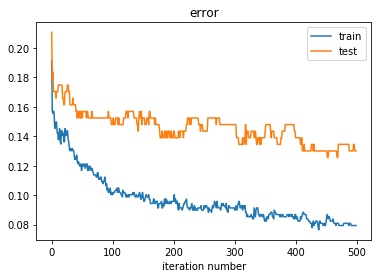

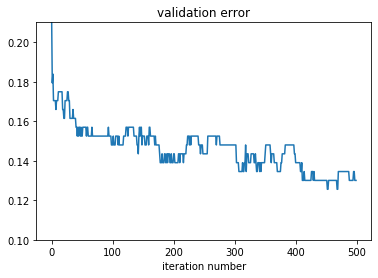

In [68]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['error'],
                         'test': clf.evals_result()['validation_1']['error']})
res = save_online_metric(clf_xgb)
res.plot(title='error')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.10,0.21), title='validation error')
plt.xlabel('iteration number')

In [76]:
from sklearn.metrics import roc_curve, auc
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [92]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_val = clf.predict(X_val)
    accuracy = np.mean(y_val == y_pred_xgb_val)
    result = {'loss': 1-accuracy, 'status': STATUS_OK}
    print('TEST ACCURACY: {0:.4f}'.format(accuracy))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 15, 1),
         'subsample' : hp.quniform('subsample', 0.5, 0.9, 0.025),
         'gamma' : hp.quniform('gamma', 0.71, 0.73, 0.000005),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 0.6, 0.025),
         'silent' : 1,
         'n_estimators': 500,
         'learning_rate': 0.2,
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)

Training with params :                                                                                                
{'colsample_bytree': 0.5750000000000001, 'gamma': 0.729315, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
TEST ROC AUC: 0.8520                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.5750000000000001, 'gamma': 0.729565, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.65, 'n_jobs': -1}
TEST ROC AUC: 0.8386                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.45

TEST ROC AUC: 0.8251                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.5, 'gamma': 0.728315, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 14.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.5, 'n_jobs': -1}
TEST ROC AUC: 0.8206                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.6000000000000001, 'gamma': 0.71523, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.625, 'n_jobs': -1}
TEST ROC AUC: 0.8520                                                                                                  
Training with params :                

TEST ROC AUC: 0.8296                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.47500000000000003, 'gamma': 0.7217100000000001, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 10.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.75, 'n_jobs': -1}
TEST ROC AUC: 0.8610                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.4, 'gamma': 0.71281, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 9.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8, 'n_jobs': -1}
TEST ROC AUC: 0.8430                                                                                                  
Training with params :        

TEST ROC AUC: 0.8520                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.525, 'gamma': 0.7224700000000001, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.525, 'n_jobs': -1}
TEST ROC AUC: 0.8386                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.55, 'gamma': 0.7110000000000001, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.775, 'n_jobs': -1}
TEST ROC AUC: 0.8251                                                                                                  
Training with params :        

TEST ROC AUC: 0.8565                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.525, 'gamma': 0.7174, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 10.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.625, 'n_jobs': -1}
TEST ROC AUC: 0.8475                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.45, 'gamma': 0.714855, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.775, 'n_jobs': -1}
TEST ROC AUC: 0.8565                                                                                                  
Training with params :                             

TEST ROC AUC: 0.8296                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.47500000000000003, 'gamma': 0.713175, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.55, 'n_jobs': -1}
TEST ROC AUC: 0.8565                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.45, 'gamma': 0.7226400000000001, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 15.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.775, 'n_jobs': -1}
TEST ROC AUC: 0.8430                                                                                                  
Training with params :    

TEST ROC AUC: 0.8430                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.5750000000000001, 'gamma': 0.71433, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 10.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8, 'n_jobs': -1}
TEST ROC AUC: 0.8475                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.6000000000000001, 'gamma': 0.720175, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.7250000000000001, 'n_jobs': -1}
TEST ROC AUC: 0.8565                                                                                                  
Training wit

TEST ROC AUC: 0.8565                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.42500000000000004, 'gamma': 0.723535, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 10.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.625, 'n_jobs': -1}
TEST ROC AUC: 0.8475                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.55, 'gamma': 0.7147600000000001, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.675, 'n_jobs': -1}
TEST ROC AUC: 0.8430                                                                                                  
Training with params :   

TEST ROC AUC: 0.8700                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.47500000000000003, 'gamma': 0.71628, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.7250000000000001, 'n_jobs': -1}
TEST ROC AUC: 0.8700                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.5, 'gamma': 0.711565, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8250000000000001, 'n_jobs': -1}
TEST ROC AUC: 0.8520                                                                                                  
Training wit

TEST ROC AUC: 0.8341                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.45, 'gamma': 0.7174550000000001, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.625, 'n_jobs': -1}
TEST ROC AUC: 0.8520                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.42500000000000004, 'gamma': 0.716165, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 7.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.7250000000000001, 'n_jobs': -1}
TEST ROC AUC: 0.8655                                                                                                  
Training with

TEST ROC AUC: 0.8475                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.45, 'gamma': 0.7181000000000001, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.775, 'n_jobs': -1}
TEST ROC AUC: 0.8610                                                                                                  
Training with params :                                                                                                
{'colsample_bytree': 0.47500000000000003, 'gamma': 0.7165400000000001, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 500, 'silent': 1, 'subsample': 0.8500000000000001, 'n_jobs': -1}
TEST ROC AUC: 0.8341                                                                                                  
Tra

In [93]:
best

{'colsample_bytree': 0.45,
 'gamma': 0.71442,
 'max_depth': 5.0,
 'min_child_weight': 7.0,
 'subsample': 0.7250000000000001}

In [102]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['n_estimators'] = 500
best_params['learning_rate'] = 0.2

In [103]:
clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='error', eval_set=[[X_train, y_train], [X_val, y_val]])

[0]	validation_0-error:0.29641	validation_1-error:0.22870
[1]	validation_0-error:0.17365	validation_1-error:0.17937
[2]	validation_0-error:0.18413	validation_1-error:0.20628
[3]	validation_0-error:0.17066	validation_1-error:0.18834
[4]	validation_0-error:0.17365	validation_1-error:0.19282
[5]	validation_0-error:0.17066	validation_1-error:0.19282
[6]	validation_0-error:0.16467	validation_1-error:0.18386
[7]	validation_0-error:0.16317	validation_1-error:0.17937
[8]	validation_0-error:0.16767	validation_1-error:0.17937
[9]	validation_0-error:0.16617	validation_1-error:0.17937
[10]	validation_0-error:0.16168	validation_1-error:0.17937
[11]	validation_0-error:0.15719	validation_1-error:0.18386
[12]	validation_0-error:0.15868	validation_1-error:0.18386
[13]	validation_0-error:0.15569	validation_1-error:0.18386
[14]	validation_0-error:0.15868	validation_1-error:0.18386
[15]	validation_0-error:0.16018	validation_1-error:0.18386
[16]	validation_0-error:0.16018	validation_1-error:0.18386
[17]	va

[139]	validation_0-error:0.11976	validation_1-error:0.15695
[140]	validation_0-error:0.12126	validation_1-error:0.15695
[141]	validation_0-error:0.11976	validation_1-error:0.15695
[142]	validation_0-error:0.11826	validation_1-error:0.15695
[143]	validation_0-error:0.11826	validation_1-error:0.15695
[144]	validation_0-error:0.11976	validation_1-error:0.15695
[145]	validation_0-error:0.11976	validation_1-error:0.15695
[146]	validation_0-error:0.11826	validation_1-error:0.15695
[147]	validation_0-error:0.11677	validation_1-error:0.16143
[148]	validation_0-error:0.11677	validation_1-error:0.15695
[149]	validation_0-error:0.11677	validation_1-error:0.15695
[150]	validation_0-error:0.11677	validation_1-error:0.15695
[151]	validation_0-error:0.11527	validation_1-error:0.15695
[152]	validation_0-error:0.11527	validation_1-error:0.15695
[153]	validation_0-error:0.11527	validation_1-error:0.15695
[154]	validation_0-error:0.11527	validation_1-error:0.15695
[155]	validation_0-error:0.11527	validat

[276]	validation_0-error:0.10778	validation_1-error:0.15695
[277]	validation_0-error:0.10629	validation_1-error:0.15247
[278]	validation_0-error:0.10778	validation_1-error:0.15247
[279]	validation_0-error:0.10629	validation_1-error:0.15695
[280]	validation_0-error:0.10629	validation_1-error:0.14798
[281]	validation_0-error:0.10629	validation_1-error:0.15695
[282]	validation_0-error:0.10629	validation_1-error:0.15695
[283]	validation_0-error:0.10629	validation_1-error:0.15695
[284]	validation_0-error:0.10629	validation_1-error:0.15695
[285]	validation_0-error:0.10629	validation_1-error:0.15695
[286]	validation_0-error:0.10629	validation_1-error:0.15247
[287]	validation_0-error:0.10629	validation_1-error:0.15247
[288]	validation_0-error:0.10629	validation_1-error:0.14798
[289]	validation_0-error:0.10629	validation_1-error:0.15695
[290]	validation_0-error:0.10778	validation_1-error:0.15247
[291]	validation_0-error:0.10629	validation_1-error:0.15247
[292]	validation_0-error:0.10629	validat

[413]	validation_0-error:0.10629	validation_1-error:0.13004
[414]	validation_0-error:0.10629	validation_1-error:0.13004
[415]	validation_0-error:0.10629	validation_1-error:0.13004
[416]	validation_0-error:0.10778	validation_1-error:0.12556
[417]	validation_0-error:0.10629	validation_1-error:0.12556
[418]	validation_0-error:0.10928	validation_1-error:0.12556
[419]	validation_0-error:0.10629	validation_1-error:0.12556
[420]	validation_0-error:0.10778	validation_1-error:0.12556
[421]	validation_0-error:0.10479	validation_1-error:0.12556
[422]	validation_0-error:0.10479	validation_1-error:0.13004
[423]	validation_0-error:0.10479	validation_1-error:0.12556
[424]	validation_0-error:0.10479	validation_1-error:0.13004
[425]	validation_0-error:0.10629	validation_1-error:0.13004
[426]	validation_0-error:0.10629	validation_1-error:0.13004
[427]	validation_0-error:0.10629	validation_1-error:0.12556
[428]	validation_0-error:0.10629	validation_1-error:0.12556
[429]	validation_0-error:0.10629	validat

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.71442,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7250000000000001,
              tree_method=None, validate_parameters=False, verbosity=None)

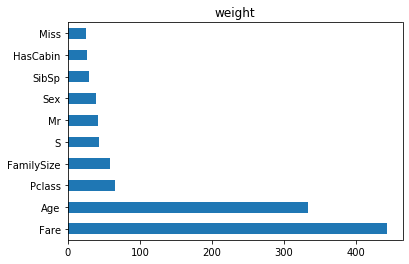

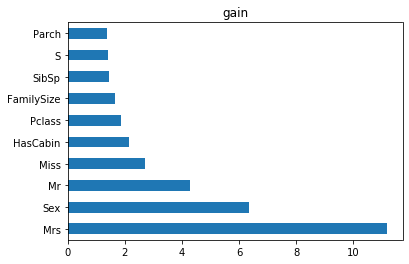

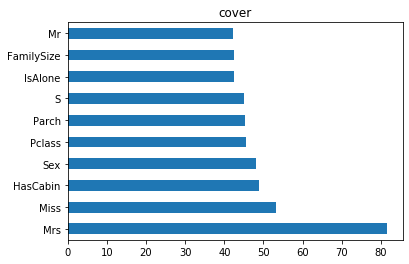

In [105]:
bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

In [111]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')
pd.read_excel('xgbfi_report.xlsx', sheet_name=2)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,Age|Fare|Sex,211.261415,2,1.016627,0.508314,105.630708,103.140359,1,18,17,19,2,1,9.666667,2.500000,2.000000
1,Pclass|Sex|SibSp,168.602728,1,0.166486,0.166486,168.602728,28.070008,2,31,60,60,1,7,26.833333,1.000000,2.000000
2,Fare|Fare|Sex,164.225190,2,0.442026,0.221013,82.112595,30.212358,3,19,42,55,4,5,21.333333,12.000000,2.000000
3,Fare|Fare|Fare,161.790114,34,15.350137,0.451475,4.758533,71.422865,4,1,1,23,40,2,11.833333,49.735294,2.470588
4,FamilySize|Miss|Mrs,154.292606,2,0.843908,0.421954,77.146303,65.330390,5,20,21,28,5,3,13.666667,2.000000,2.000000
5,Mr|Parch|Pclass,88.068119,1,0.195539,0.195539,88.068119,17.220756,6,32,59,58,3,12,28.333333,3.000000,2.000000
6,Age|Mr|Pclass,72.898312,1,0.444354,0.444354,72.898312,32.392621,7,33,41,24,6,4,19.166667,3.000000,2.000000
7,Fare|Sex|SibSp,69.072610,2,0.551653,0.275826,34.536305,19.253238,8,21,37,49,10,10,22.500000,6.000000,2.000000
8,Age|Age|Age,55.885940,11,5.595505,0.508682,5.080540,28.490319,9,2,2,17,37,6,12.166667,58.636364,2.272727
9,FamilySize|FamilySize|HasCabin,51.979961,1,0.264646,0.264646,51.979961,13.756313,10,34,54,50,7,14,28.166667,0.000000,2.000000


In [104]:
test_predictions = clf_xgb.predict(test)#.drop('Survived',axis=1))
test_prediction = pd.DataFrame({'PassengerId': test.index, 
                                'Survived': test_predictions})
test_prediction.to_csv('gender_submission.csv', header = True, index = False) 
### gets 0.75598 on public leaderboard on kaggle

In [117]:
best_params = {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.7191919191919192, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 6, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 21, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8,}

clf = xgb.XGBClassifier(**best_params)
clf.fit(X_train, y_train)
t_pr = clf.predict(X_train)
v_pr = clf.predict(X_val)
print(f'train accuracy: {np.mean(t_pr == y_train)}')
print(f'val accuracy: {np.mean(v_pr == y_val)}')

train accuracy: 0.8817365269461078
val accuracy: 0.8385650224215246


In [118]:
test_predictions = clf.predict(test)#.drop('Survived',axis=1))
test_prediction = pd.DataFrame({'PassengerId': test.index, 
                                'Survived': test_predictions})
test_prediction.to_csv('gender_submission.csv', header = True, index = False) 
### gets 0.75598 on public leaderboard on kaggle